# Project 1 - EECS 731
*By Grant Gollier*

## Datasets

- US Hostpials: https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/data
- County Population: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html
- GIS Data for mapping: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html


## Combinations

The first combination I thought of was to combine the US Hospital dataset with the Census data to figure out the number of people per hospital in all the various counties.

To then expand on this I calculated the number of people per hospital beds in order to better account for different sized hospitals.

Finally, to better vizualize this, I combined this above agregate data with a US Census GIS dataset in order to vizualize this population per bed density against a map of the US


## US State to 2-letter code map
Code from: https://gist.github.com/rogerallen/1583593

This was needed so we can have a standard way to refer to states

In [1]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [2]:
import pandas
import numpy as np

In [3]:
raw_hospital_data = pandas.read_csv("../data/Hospitals.csv")
raw_counties_data = pandas.read_excel("../data/co-est2019-annres.xlsx", header=3)

### Cleaning and Preparing the Census Data

First, I had to remove some comments that are at the end of the dataset. Then, in order to make matching counties later easier, I stripped off the various suffixes that various states use on their counties as our other datasets don't use these suffixes. Furthermore, I had to fix a few spelling mistakes so that this dataset will match the correct names used in other datasets

In [4]:
# Slice off the notes at the bottom
raw_counties_data = raw_counties_data[:-6]

as_list = raw_counties_data.index.tolist()
for row in as_list:
    name = raw_counties_data.loc[row]['Unnamed: 0']
    name = name.strip('.')
    state_code = ""
    if name.find(',') > 0:
        state = name[name.find(',') + 2:]
        state_code = us_state_abbrev[state]
        name = name[:name.find(',')].upper() + ", " + state_code
    name = name.replace(" COUNTY", "")
    name = name.replace(" PARISH", "")
    if state_code == "VA":
        name = name.replace(" CITY", "")
    if state_code == "AK":
        name = name.replace(" CENSUS AREA", "")
        name = name.replace(" CITY AND BOROUGH", "")
        name = name.replace(" BOROUGH", "")
        name = name.replace(" AREA", "")
        name = name.replace(" MUNICIPALITY", "")
    if name == "LASALLE, LA":
        name = "LA SALLE, LA"
    if name == "LASALLE, IL":
        name = "LA SALLE, IL"
    if name == "OGLALA LAKOTA, SD":
        name = "SHANNON, SD"

    raw_counties_data['Unnamed: 0'].replace(raw_counties_data.loc[row]['Unnamed: 0'], value=name, inplace=True)
    
raw_counties_data.set_index('Unnamed: 0', inplace=True)

### Preparing Hospital Dataset

First, I removed all the data for the US territories as our Hospital dataset doesn't contain information about them. I next had to fix some spelling errors to get various counties to line up with the Census as well as make sure the formating matches what the Census uses. Finally, I replaced the missing value in beds (-999) with NaN so we have a standard way to know that the information is missing. You can see the basic statistics about this dataset below.

In [5]:
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("PR")]
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("VI")]
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("GU")]
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("MP")]
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("PW")]
raw_hospital_data = raw_hospital_data[~raw_hospital_data.STATE.str.contains("AS")]


def label_state_county(row):
    if row['STATE'] == 'VA' and "CITY" in row['COUNTY']:
        row['COUNTY'] = row['COUNTY'].replace(" CITY", "")
    elif row['COUNTY'] == "PENNINTON":
        row['COUNTY'] = "PENNINGTON"
    elif row['COUNTY'] == "ST LOUIS":
        row['COUNTY'] = "ST. LOUIS"
    elif row['COUNTY'] == "DONA ANA":
        row['COUNTY'] = "Doña Ana".upper()
    elif row['COUNTY'] == "SAINT CROIX":
        row['COUNTY'] = "ST. CROIX"
    elif row['COUNTY'] == "ST JOSEPH":
        row['COUNTY'] = "ST. JOSEPH"
    elif row['COUNTY'] == "SAINT BERNARD":
        row['COUNTY'] = "ST. BERNARD"
    elif row['COUNTY'] == "MONGOMERY":
        row['COUNTY'] = "MONTGOMERY"
    elif row['COUNTY'] == "WRANGELL-PETERSBURG":
        row['COUNTY'] = "WRANGELL"
    elif row['COUNTY'] == "ST CHARLES":
        row['COUNTY'] = "ST. CHARLES"
    elif row['COUNTY'] == "ST CLAIR":
        row['COUNTY'] = "ST. CLAIR"
    return row['COUNTY'] + ", " + row['STATE']

raw_hospital_data['COUNTY_STATE'] = raw_hospital_data.apply(label_state_county, axis=1)

raw_hospital_data['BEDS'].replace(-999, value=np.nan, inplace=True)

raw_hospital_data.describe()

,X,Y,FID,ID,ZIP,POPULATION,LATITUDE,LONGITUDE,NAICS_CODE,ST_FIPS,TTL_STAFF,BEDS
count,7.513000e+03,7.513000e+03,7513.000000,7.513000e+03,7513.000000,7513.000000,7513.000000,7513.000000,7513.000000,7513.00000,7513.0,7224.000000
mean,-1.033206e+07,4.542538e+06,3801.328364,2.880154e+07,54194.659657,28.116598,37.534197,-92.814508,622142.304006,29.00559,-999.0,146.009967
std,1.659958e+06,7.771289e+05,2196.352135,4.530573e+07,27137.957590,387.763763,5.410526,14.911658,67.305727,15.78928,0.0,177.075303
min,-1.966350e+07,2.178457e+06,1.000000,4.000000e+00,1040.000000,-999.000000,19.199663,-176.640263,622110.000000,1.00000,-999.0,2.000000
25%,-1.095546e+07,3.967525e+06,1903.000000,4.144113e+06,32501.000000,25.000000,33.542427,-98.414607,622110.000000,17.00000,-999.0,30.000000
50%,-1.003868e+07,4.585822e+06,3800.000000,1.003892e+07,55435.000000,64.000000,38.045266,-90.179037,622110.000000,29.00000,-999.0,76.000000
75%,-9.129520e+06,5.063949e+06,5703.000000,2.577709e+07,77030.000000,175.000000,41.348952,-82.011873,622110.000000,42.00000,-999.0,196.000000
max,-7.488241e+06,1.150485e+07,7611.000000,1.967841e+08,99929.000000,1592.000000,71.297725,-67.268016,622310.000000,56.00000,-999.0,1592.000000


### Combining Hospital Data with Census

Here we match on the county and state name and then count the number of hospitals in a given county.

In [6]:
raw_counties_data['HOSPITALS'] = 0

def count_hospitals(row):
    return np.nansum(raw_hospital_data['COUNTY_STATE'] == row.name)

raw_counties_data['HOSPITALS'] = raw_counties_data.apply(count_hospitals, axis=1)

## Basic Analysis and Visualization
 

### General Statistics of the Hospitals per County

In [7]:
raw_counties_data['HOSPITALS'].describe()

count    3143.000000
mean        2.396437
std         5.420041
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       129.000000
Name: HOSPITALS, dtype: float64

### Hospitals per County Histogram

Here you can see the number of Hospitals per county. As the statistics above suggested, most counties have only a few hospitals.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35e4499280>]],
      dtype=object)

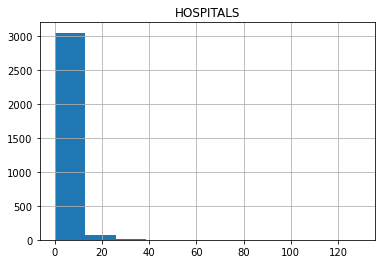

In [8]:
%matplotlib inline
raw_counties_data.hist(column='HOSPITALS')

To see a bit more detail, below is the same histogram without the outliers of the counties with more than 10 hospitals.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35e426e520>]],
      dtype=object)

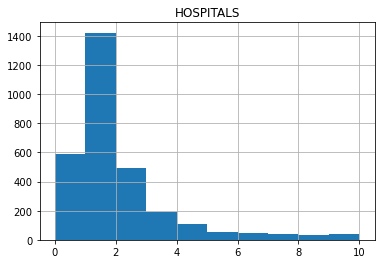

In [9]:
raw_counties_data.loc[raw_counties_data['HOSPITALS'] <= 10].hist(column='HOSPITALS')

### People per Hospital in each County

Looking at this plot where I saw that most hospitals serve less than 50,000 people is where I got that idea to then focus on number of beds. This will also better account for larger hospitals.

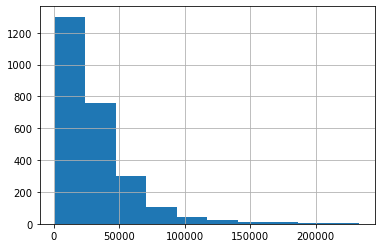

In [10]:
(raw_counties_data['Census'] / raw_counties_data.loc[raw_counties_data['HOSPITALS'] > 0]['HOSPITALS']).hist()

To see a bit more detail in the body, I plotted all the counties with less than 50,000 people per hospital. As you can see, the data skews a bit low, but for the most part it's pretty much what you'd expect from the above larger histogram.

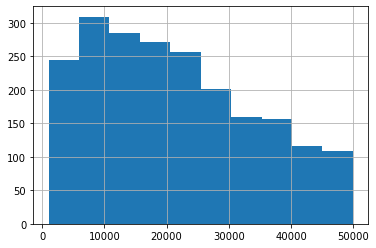

In [11]:
people_per_hospital = (raw_counties_data['Census'] / raw_counties_data.loc[raw_counties_data['HOSPITALS'] > 0]['HOSPITALS'])
people_per_hospital.loc[people_per_hospital < 50000].hist()

### Hospital Beds per County

Here we sum over all the different hospitals in county and count up all the beds. As you can see in the histogram, most counties seem to be served by realtively few and small hospitals while there's a long tail of larger hospitals that have a lot of beds.

count     3143.000000
mean       337.410118
std       1130.889870
min          0.000000
25%         20.000000
50%         50.000000
75%        195.500000
max      30147.000000
Name: BEDS, dtype: float64

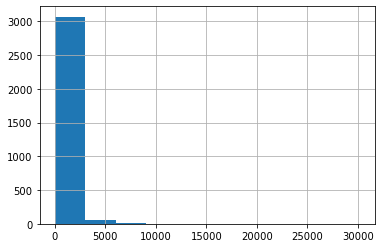

In [12]:
raw_counties_data['BEDS'] = 0
hospital_bed_data = raw_hospital_data.copy()

def count_beds(row):
    return np.nansum(hospital_bed_data.loc[hospital_bed_data['COUNTY_STATE'] == row.name]["BEDS"])

raw_counties_data['BEDS'] = raw_counties_data.apply(count_beds, axis=1)

raw_counties_data['BEDS'].hist()
raw_counties_data['BEDS'].describe()

### People per Bed

Now, to adjust for the size of the county, we can use the Census data to calculate the number of beds per person in a county.

In [13]:
def count_people_per_bed(row):
    if row['BEDS'] <= 0:
        return np.nan
    else:
        return row['Census'] / row['BEDS']

raw_counties_data['PEOPLE_PER_BED'] = raw_counties_data.apply(count_people_per_bed, axis=1)

people_per_bed_data = raw_counties_data.copy()
people_per_bed_data['PEOPLE_PER_BED'].describe()

count     2541.000000
mean       501.902490
std        782.411018
min          3.433766
25%        234.666667
50%        362.580000
75%        605.254237
max      30181.250000
Name: PEOPLE_PER_BED, dtype: float64

### Ploting the data on a Map

The base of this implementation came from https://shallowsky.com/blog/programming/plotting-election-data-basemap.html which was a great source for figuring out dealing with the federal GIS data for counties. Luckily, with the processing we did on the Census dataset earlier, we're able to map the county names from the GIS dataset directly to that dataset and can then uses the values we calculated above for the plot. Counties with either no bed data or no beds are white on the graph. I then choose to represent the density using a heatmap.

### Cleaning GIS Data

For cleaning the GIS data, I just made the necessary adjustments as we plot the data. For example, some of the datapoints for the edges of Alaska were at a position of around 10^29 which is clearly just bad data for an edge that either shouldn't be there or got messed up during creation. I additionally had to map the number representation of each state that the Census uses to the two letter abbreviation of the state since that's what we use elsewhere. 

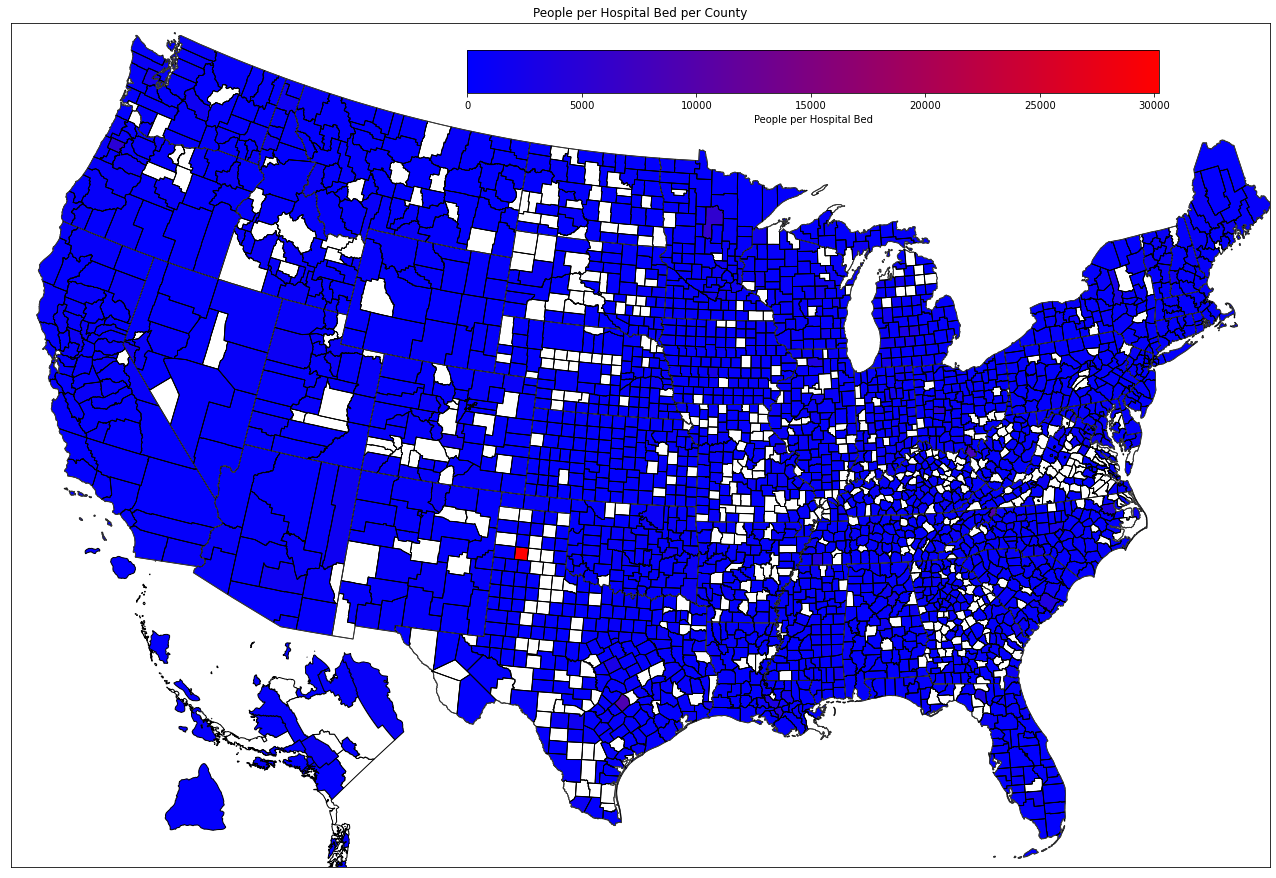

In [14]:
import math
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import LinearSegmentedColormap, Normalize

def move_ak_and_hi(countyseg, state):
    # Some of the segments in the GIS data are very very wrong
    if countyseg[0][0] > 3 * 10 ** 29:
        return None
    if state == 'AK':
        # Alaska is too big. Scale it down to 35% first, then transate it.
        countyseg = list(map(lambda x: (0.35*x[0] + 1100000, 0.35*x[1]-1500000), countyseg))

    if state == 'HI':
        countyseg = list(map(lambda x: (x[0] + 5750000, x[1]-1400000), countyseg))
        
    return countyseg

def draw_us_map():
    # Set the lower left and upper right limits of the bounding box:
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='i',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')

    # Read state boundaries.
    shp_info = m.readshapefile('../data/cb_2018_us_state_5m', 'states',
                               drawbounds=True, color='lightgrey')

    # Read county boundaries
    shp_info = m.readshapefile('../data/cb_2018_us_county_5m',
                               'counties',
                               drawbounds=True)
    
    ax = plt.gca()
    
    maxstatefp = 0
    states = [None] * 80
    for state in m.states_info:
        statefp = int(state["STATEFP"])
        # print statefp, state["NAME"]
        if statefp > maxstatefp:
            maxstatefp = statefp
        # Many states have multiple entries in m.states (because of islands)
        # Only need to add it once.
        if not states[statefp]:
            states[statefp] = state["NAME"]
    
    for i, county in enumerate(m.counties_info):
        state = states[int(county['STATEFP'])]
        if state not in us_state_abbrev:
            continue
        state = us_state_abbrev[state]
        county_state = county['NAME'].upper() + ", " + state
        if county_state in people_per_bed_data.index:
            red = people_per_bed_data['PEOPLE_PER_BED_NORMALIZED'][county_state]
            if type(red) is not np.float64:
                red = red.values[0]
            blue = 1 - red
            green = 0
            if math.isnan(red):
                red = 1
                blue = 1
                green = 1
            countyseg = move_ak_and_hi(m.counties[i], state)
            
            if countyseg:
                poly = Polygon(countyseg, facecolor=(red, green, blue), edgecolor=(0, 0, 0))
                ax.add_patch(poly)
            
        else:
            countyseg = move_ak_and_hi(m.counties[i], state)
            if countyseg:
                poly = Polygon(countyseg, facecolor=(1, 1, 1), edgecolor=(0, 0, 0))
                ax.add_patch(poly)

def plot_people_per_bed():
    people_per_bed_data['PEOPLE_PER_BED_NORMALIZED'] = people_per_bed_data['PEOPLE_PER_BED']/people_per_bed_data['PEOPLE_PER_BED'].max()
    
    plt.figure(figsize=(24,12))
    fig = plt.gcf()
    draw_us_map()
    ax = plt.gca()
    plt.title('People per Hospital Bed per County')
    # Get rid of some of the extraneous whitespace matplotlib loves to use.
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)

    # Make a user-defined colormap.
    cm1 = LinearSegmentedColormap.from_list("b->r CMap",["b","r"])

    # Make a normalizer that will map the time values from
    # [start_time,end_time+1] -> [0,1].
    cnorm = Normalize(vmin=0,vmax=people_per_bed_data['PEOPLE_PER_BED'].max())


    cax = fig.add_axes([0.4, 0.9, 0.4, 0.05])
    cb = ColorbarBase(cax, cmap=cm1, norm=cnorm, orientation='horizontal')
    cb.ax.set_xlabel('People per Hospital Bed')
    plt.show()
    
plot_people_per_bed()

As you can see, there are a handful of outlying counties that make this plot essentially worthless. Next, we can try limiting the plot to only counties with under 2,000 people per hospital bed.

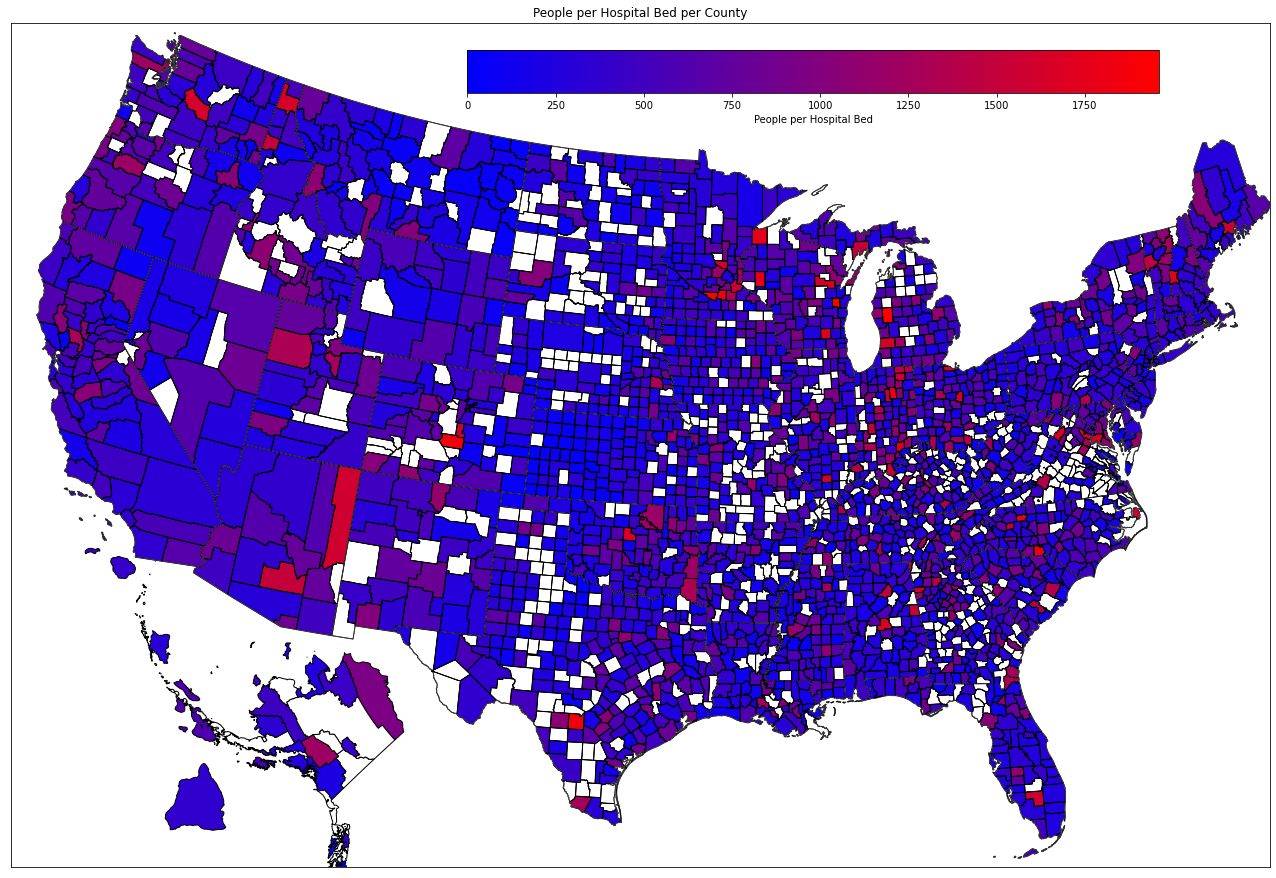

In [15]:
people_per_bed_data = raw_counties_data.loc[raw_counties_data['PEOPLE_PER_BED'] < 2000].copy()
plot_people_per_bed()

As you can see, we can get a bit more information by limiting our range to 0 to 2,000 people per hospital bed, but it's still a bit hard to tell due to outliers. Below, you can see what it looks like limiting it to only under 1,000.

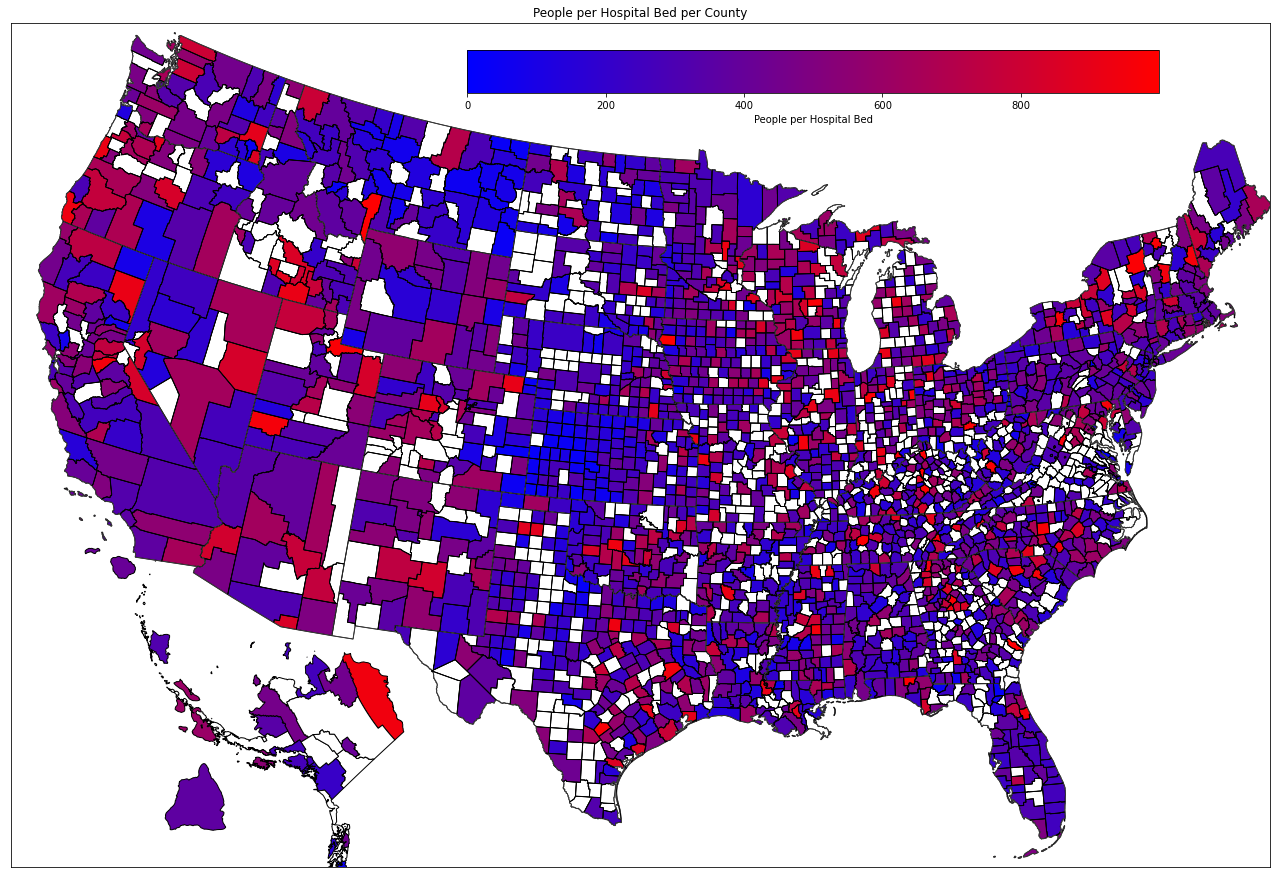

In [16]:
people_per_bed_data = raw_counties_data.loc[raw_counties_data['PEOPLE_PER_BED'] < 1000].copy()
plot_people_per_bed()

While this is definitely more understandable, we've lost all information from more populated counties that tend to have more people per bed than the less populated ones.